[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Unsupervised learning with Autoencoder

We first play with MNIST dataset and pieces of code seen during the course.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

## Loading MNIST

MNIST is a dataset made of 60,000 images of handwritten digits (0 to 9) of size $28\times 28$.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [ ]:
# to be modified if not on colab
ROOT_DIR = Path.home()
root_dir = os.path.join(ROOT_DIR,'data/MNIST/')
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=True, download=True, transform=transforms.ToTensor()),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

## Helper Functions

In [ ]:
def to_img(x):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    The encoder is called by model.encoder
    The decoder is called by model.decoder
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)

    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

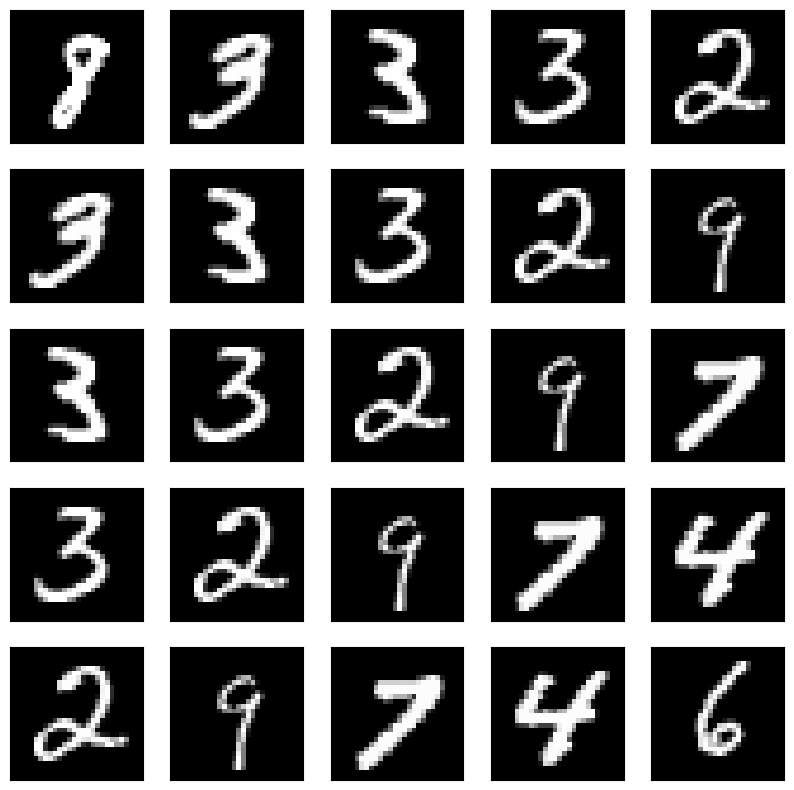

In [ ]:
# Visualise some images
data, _ = next(iter(train_loader))
data = data.view([-1, 28, 28])
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
  for j in range(5):
      ax[i][j].imshow(data[i*5+j])
      ax[i][j].get_xaxis().set_visible(False)
      ax[i][j].get_yaxis().set_visible(False)
      plt.gray()
plt.show()

## Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

1. Implement this network. Give the number of parameters and check it numerically.

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

2. What should be the size of the input dimension? How about the encoding dimension?

3. We'll be using [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam). Remind how SGD works, and the main features of Adam. What is the default learning rate?

In [ ]:
input_dim = 784
encoding_dim = 64

model = AutoEncoder(input_dim, encoding_dim)  # Create an instance of the model with these parameters
model = model.to(device)                      # Put the model on the device
optimizer = optim.Adam(model.parameters())    # Define an optimizer

4. Let us start with a simple loss: the $L_2$ norm between true and reconstructed images. Implement it using [torch documentation](https://pytorch.org/docs/stable/nn.html).

In [ ]:
loss_fn = torch.nn.MSELoss()                  # Define a loss function

5. Fill in the following function allowing to train the model.

In [ ]:
def train_model(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

6. Train the model for 10 epochs. Comment on the evolution of the loss.

In [ ]:
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.120947
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.043095
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.031149
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.027753
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.023637
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.021153
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.020431
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.018649
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.018641
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.017558
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.017208
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.016596
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.017080
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.017047
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.016638
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.016036
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.016610
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.016470
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.015813
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.015913
Train Epoch: 6 [51200/60000 (85%)]	

7. Plot the reconstruction on some test images using the  ``` plot_reconstructions ``` function. Comment. What are the flaws of the model, and what can we improve?

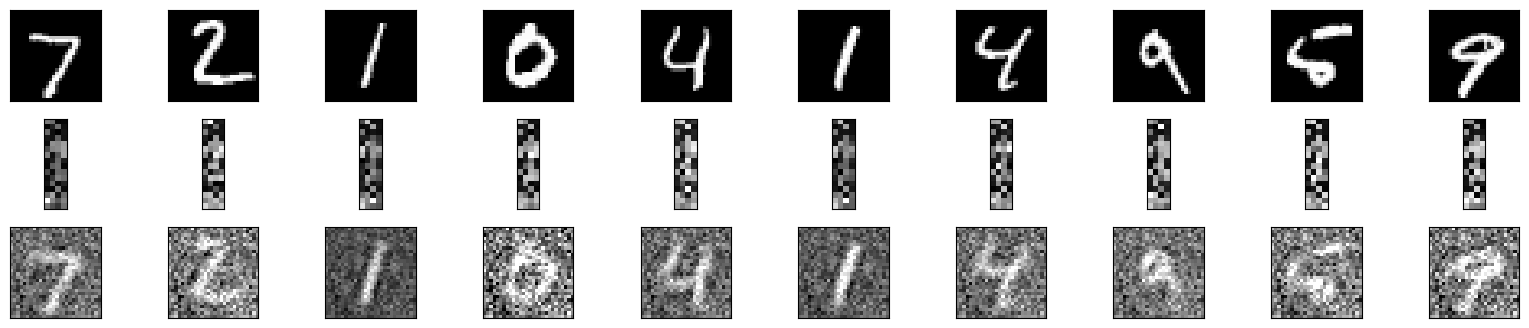

In [ ]:
plot_reconstructions(model)

## 1. Stacked Autoencoder

Now you will code an autoencoder where both the encoder and the decoder are multilayer perceptron (MLP). You can take for the encoder a first hidden layer with dimension 128, a second one with dimension 64 and then the code of dimension 32. For the decoder, you can take the same sequence of dimensions in reverse order.

8. First, draw a quick diagram of this network and implement it.

In [ ]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),

        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

9. Train your new model as done before and plot some the reconstruction. Is it working better visually?

In [ ]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [ ]:
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.115648
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.043630
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.035132
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.031328
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.026268
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.025014
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.024052
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.022872
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.022928
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.022489
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.021127
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.020562
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.020192
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.019952
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.019860
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.019631
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.018642
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.018087
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.018294
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.018307
Train Epoch: 6 [51200/60000 (85%)]	

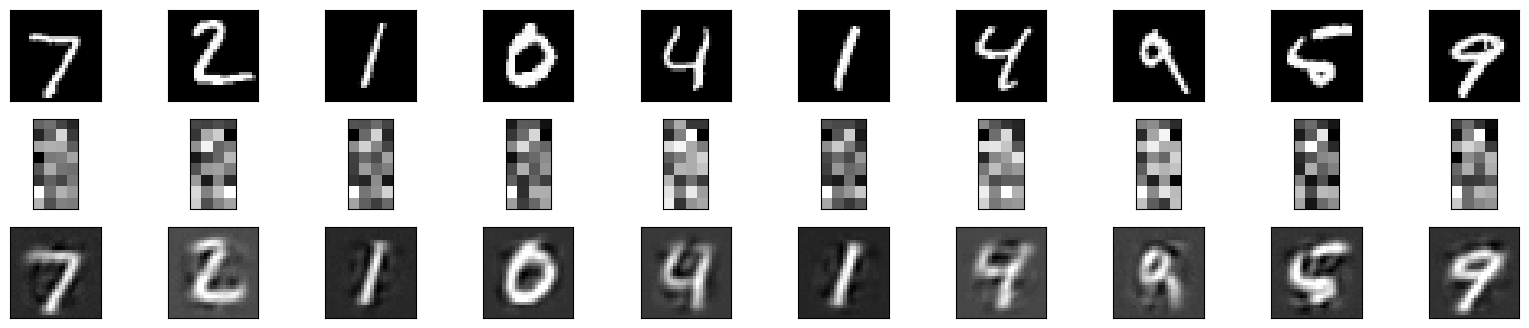

In [ ]:
plot_reconstructions(model)

10. Replace the `MSELoss` with a `BCEWithLogitsLoss` for each pixel. Note the unusual use of `BCEWithLogitsLoss`! You can have a look at the definition of [Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy).

In [ ]:
model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.693153
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.259461
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.232599
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.217652
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.180792
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.170090
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.163029
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.156870
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.151964
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.147059
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.143773
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.137922
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.139181
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.140354
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.134487
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.129697
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.129765
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.127336
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.130495
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.121987
Train Epoch: 6 [51200/60000 (85%)]	

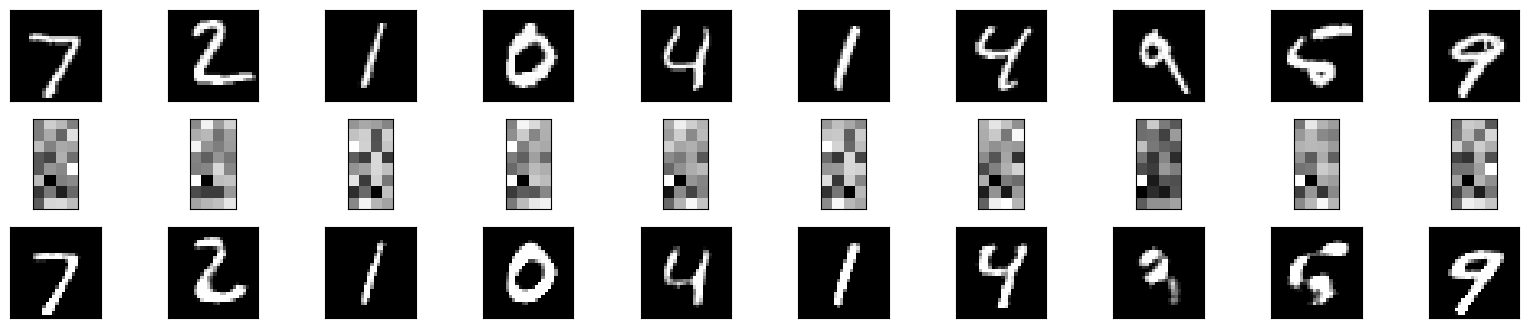

In [ ]:
plot_reconstructions(model)

## 2. Optional

At this stage, you can code the interpolation described in the lesson to obtain:

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/interp_AE.png)

In [ ]:
data, labels = next(iter(test_loader))
labels

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [ ]:
encoded_0 = model.encoder(data[1].view(-1,784).to(device))
encoded_1 = model.encoder(data[9].view(-1,784).to(device))

In [ ]:
alpha = torch.linspace(0,1,steps=10)
alpha = alpha.view(-1,1).to(device)
interp = (1-alpha)*encoded_0+alpha*encoded_1

In [ ]:
decoded_imgs = model.decoder(interp)

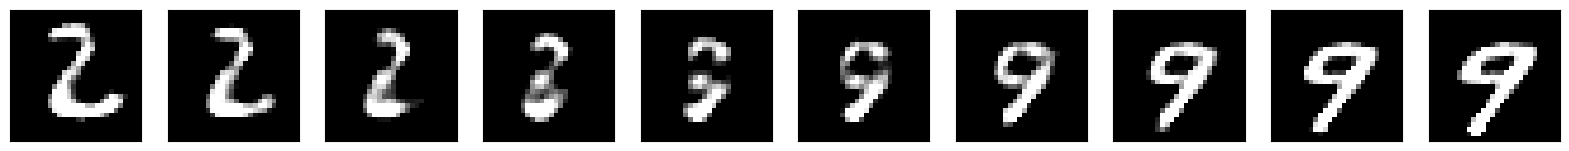

In [ ]:
decoded_imgs = to_img(decoded_imgs)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)

    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
#encoded_0 = model.encoder(data[0].view(-1,784).to(device))
#encoded_1 = model.encoder(data[6].view(-1,784).to(device))
n = 100
alpha = torch.linspace(0,1,steps=n)
alpha = alpha.view(-1,1).to(device)
interp = (1-alpha)*encoded_0+alpha*encoded_1
decoded_imgs = model.decoder(interp)
decoded_imgs = to_img(decoded_imgs)

In [ ]:
import matplotlib.animation as animation

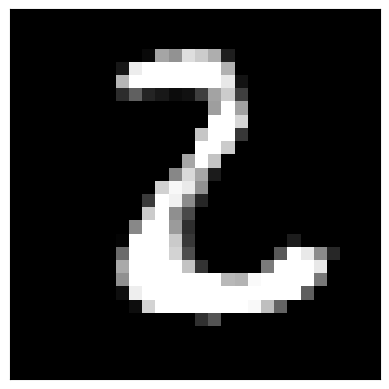

In [ ]:
fig, ax = plt.subplots()
ims = []
for i in range(len(decoded_imgs)):
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    im = ax.imshow(decoded_imgs[i], animated=True)
    if i == 0:
        ax.imshow(decoded_imgs[0])  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
#writergif = animation.PillowWriter(fps=30)
#ani.save("AE_interpolate.gif",writer=writergif)
plt.show()

# 3. Implement a denoising AE:


11. Use the previous code and implement minimal modifications to tranform the AE into a denoising AE. First apply some noise to your input and try to recover the original data at the output. For the noise, you can add some random noise or erase some of the pixels. In this last case, you should obtain something like:
![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/denoising_AE.png)
The first line corresponds to the original digit, the second line to the noisy version of the digit given as input to your network, the third line is the associated code and the last line is the denoised digit obtained by your decoder from the code.

In [ ]:
# You need first to modify the training process by adding noise to your data
# Hint if you want to erase pixels: https://stackoverflow.com/questions/49216615/is-there-an-efficient-way-to-create-a-random-bit-mask-in-pytorch
def train_denoiser(model,loss_fn,data_loader=None,epochs=1,optimizer=None, noise=0.1):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            mask = torch.empty_like(data).uniform_() > noise
            noisy_data = data * mask
            # mask = torch.zeros_like(data)
            # level = 10
            # mask[:,:,-level:,:] = torch.ones(mask.shape[0],1,level,28)
            # noisy_data = mask * data

            data = data.view([-1, 784]).to(device)
            noisy_data = noisy_data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            output = model(noisy_data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))

In [ ]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
train_denoiser(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer, noise=0.8)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.693523
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.259805
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.250454
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.242994
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.232541
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.223234
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.211650
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.196010
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.185739
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.185403
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.178326
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.175980
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.174245
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.166692
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.170070
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.167890
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.163315
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.163923
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.161560
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.163991
Train Epoch: 6 [51200/60000 (85%)]	

In [ ]:
# Now you need to modify the plot function
def plot_denoising(model, noise=0.1):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, , the second row is the noisy digits,
    the third row is the encoded vector and
    the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    #
    # your code here to compute
    # noisy_data
    # encoded_imgs
    # decoded_imgs
    mask = torch.empty_like(data).uniform_() > noise
    noisy_data = mask * data
    # mask = torch.zeros_like(data)
    # level = 10
    # mask[:,:,-level:,:] = torch.ones(10,1,level,28)
    # noisy_data = mask * data
    data = data.to(device)
    noisy_data = noisy_data.to(device)
    noisy_data.requires_grad = False
    data = data.view([-1, 784])
    noisy_data = noisy_data.view([-1,784])
    encoded_imgs = model.encoder(noisy_data)
    decoded_imgs = model.decoder(encoded_imgs)
    #
    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display code
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

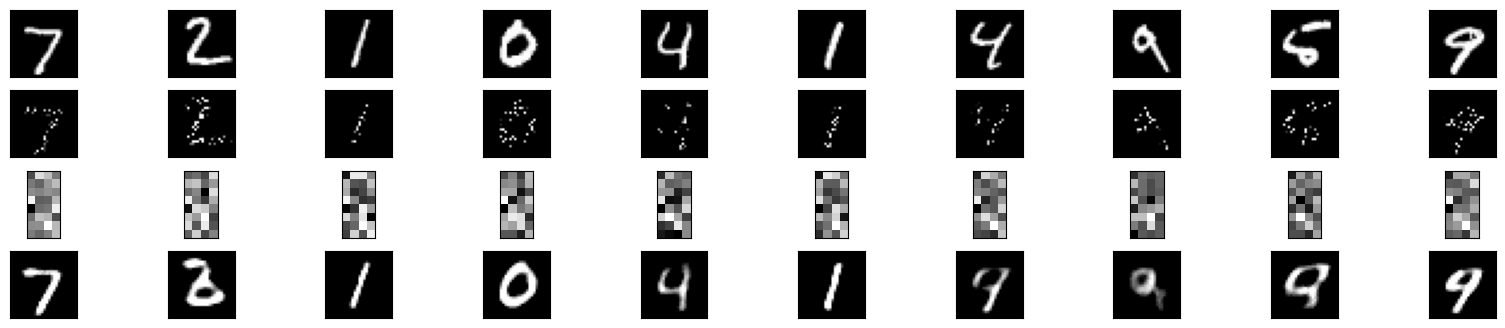

In [ ]:
plot_denoising(model, noise=0.8)

## 4. Optional: how to deal with convolutions?

Hint: start by decreasing the size of your image with `Conv2d` by using a `stride` like:

In [ ]:
conv = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2)
x = torch.randn(2, 8, 64, 64)
y = conv(x)
y.shape

torch.Size([2, 16, 32, 32])

Now use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (or [deconvolution](https://distill.pub/2016/deconv-checkerboard/)) with the same parameters:

In [ ]:
convt = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, padding=1, stride=2)

In [ ]:
convt(y).shape

torch.Size([2, 8, 63, 63])

To get the same size as `x`, play with `output_padding`.

Now, you have all the tools to build a convolutional autoencoder!

In [ ]:
class Conv_AutoEncoder(nn.Module):
    def __init__(self):
        super(Conv_AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def train_model_conv(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            #data = data.view([-1, 784]).to(device)\
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [ ]:
model = Conv_AutoEncoder()
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
data, _ = next(iter(test_loader))
data = data.to(device)

In [ ]:
model(data).shape

torch.Size([10, 1, 28, 28])

In [ ]:
train_model_conv(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.795478
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.152258
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.094149
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.087822
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.079638
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.075605
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.073431
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.071529
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.069542
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.070828
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.069395
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.068866
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.068416
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.067747
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.067608
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.065835
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.068170
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.067907
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.067225
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.066422
Train Epoch: 6 [51200/60000 (85%)]	

In [ ]:
class Conv_Up(nn.Module):
    def __init__(self):
        super(Conv_Up, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, 3, stride=3, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, stride=3, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = Conv_Up()
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
def train_model_up(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            output = model(F.avg_pool2d(data, kernel_size = 2))
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [ ]:
train_model_up(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.660330
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.308715
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.211906
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.177065
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.121762
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.106291
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.104519
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.096026
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.090636
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.089795
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.089216
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.083671
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.082716
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.083747
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.082364
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.083903
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.080113
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.078819
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.080950
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.078422
Train Epoch: 6 [51200/60000 (85%)]	

In [ ]:
def to_img(x, size=28):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, size, size])
    return x

def plot_up_conv(model):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    noisy_data = F.avg_pool2d(data, kernel_size = 2)
    #data += noise * torch.randn(data.size())
    data = data.to(device)
    noisy_data = noisy_data.to(device)

    #data = data.view([-1, 784])
    #noisy_data = noisy_data.view([-1,784])
    noisy_data.requires_grad = False
    encoded_imgs = model.encoder(noisy_data)
    decoded_imgs = model.decoder(encoded_imgs)

    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data, size=14)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

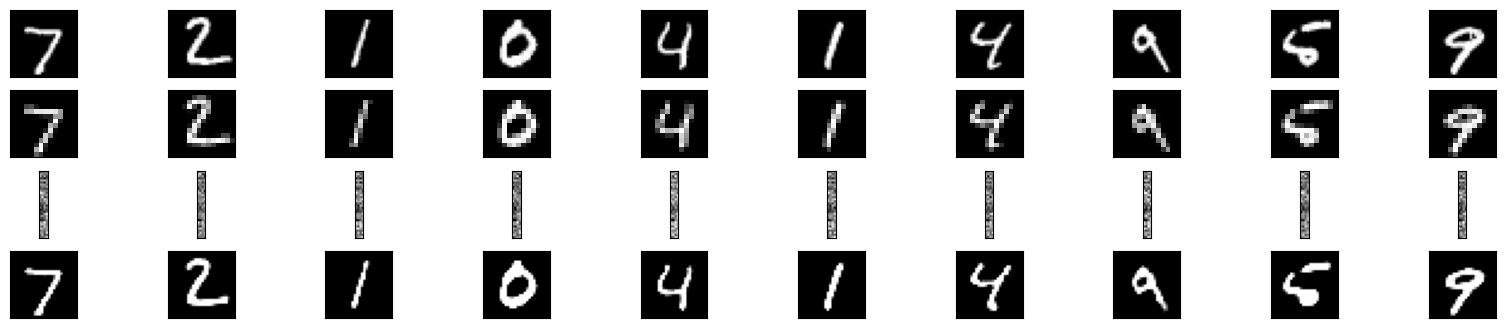

In [ ]:
plot_up_conv(model)

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)